We will be doing Time-Series forecast in our project.

A ***Time Series*** is defined as a series of data points recorded at different time intervals. The time order can be daily, monthly, or even yearly.

We will mostly be focusing on ***Univariate Time Series Forecasting*** which is we use only the previous values of the time series to predict its future values.



In [ ]:
#Install dependencies (if needed) in this box

In [1]:
#DEFINE CONSTANTS Here
DATASET_PATH="/content/TSLA_2.csv"  
TRAIN_SPLIT=0.8
TEST_SPLIT=1-TRAIN_SPLIT

In [2]:
#Install necessary Libraries + Packages here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM
from keras.models import Sequential
from pylab import rcParams
rcParams['figure.figsize'] = 17,15
rcParams['lines.color'] = 'teal'
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
from scipy.stats import norm, skew
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import math
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
import statistics
from keras.layers import SimpleRNN

DataSet obtained from here https://finance.yahoo.com/quote/TSLA/history?period1=1293840000&period2=1669507200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [ ]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-01-03,1.789333,1.800000,1.726667,1.774667,1.774667,19245000
1,2011-01-04,1.777333,1.796667,1.734667,1.778000,1.778000,17811000
2,2011-01-05,1.765333,1.793333,1.746000,1.788667,1.788667,21700500
3,2011-01-06,1.788667,1.866667,1.787333,1.858667,1.858667,30918000
4,2011-01-07,1.866667,1.905333,1.860000,1.882667,1.882667,33718500


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2991,2022-11-18,185.050003,185.190002,176.550003,180.190002,180.190002,75904900
2992,2022-11-21,175.850006,176.770004,167.539993,167.869995,167.869995,92882700
2993,2022-11-22,168.630005,170.919998,166.190002,169.910004,169.910004,78452300
2994,2022-11-23,173.570007,183.619995,172.500000,183.199997,183.199997,109536700
2995,2022-11-25,185.059998,185.199997,180.630005,182.860001,182.860001,50672700


High -> Highest Price of the stock for that particular date.

Low -> Lowest Price of the stock for that particular date.

Open -> Opening Price of the stock.

Close -> Closing Price of the stock.

Volume -> Total amount of Trading Activity.

AdjClose -> Adjusted values factor in corporate actions such as dividends, stock splits, and new share issuance.

In [ ]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 2996 rows and 7 columns


In [ ]:
len(df['Date'].unique())

2996

It means we don't have duplicate Values

In [ ]:
print("The DataSet used contains the stock values between ( ",df.Date.min(),", ", df.Date.max()," )")

The DataSet used contains the stock values between (  2011-01-03 ,  2022-11-25  )


In [ ]:
df.Date=pd.to_datetime(df['Date'])
   

In [ ]:
df.set_index('Date',inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,1.789333,1.800000,1.726667,1.774667,1.774667,19245000
2011-01-04,1.777333,1.796667,1.734667,1.778000,1.778000,17811000
2011-01-05,1.765333,1.793333,1.746000,1.788667,1.788667,21700500
2011-01-06,1.788667,1.866667,1.787333,1.858667,1.858667,30918000
2011-01-07,1.866667,1.905333,1.860000,1.882667,1.882667,33718500


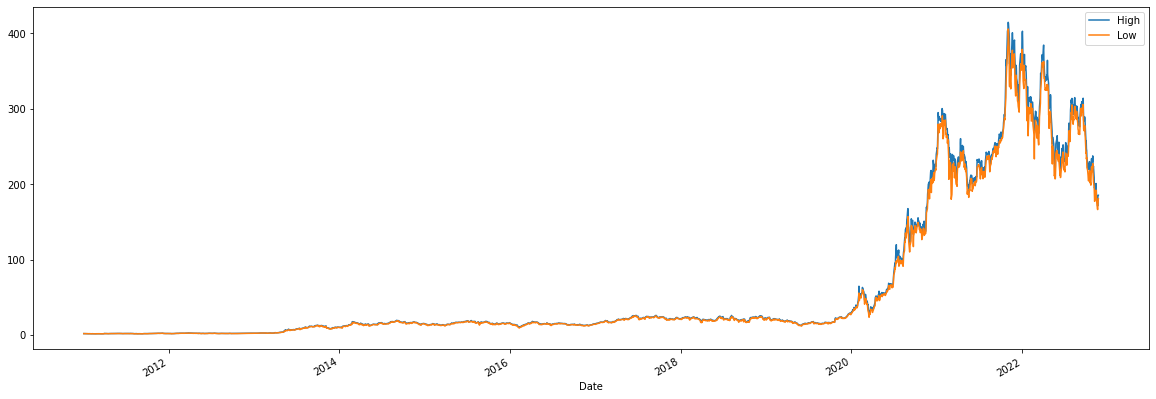

In [ ]:
df[['High', 'Low']].plot(figsize = (20, 7), alpha = 1)

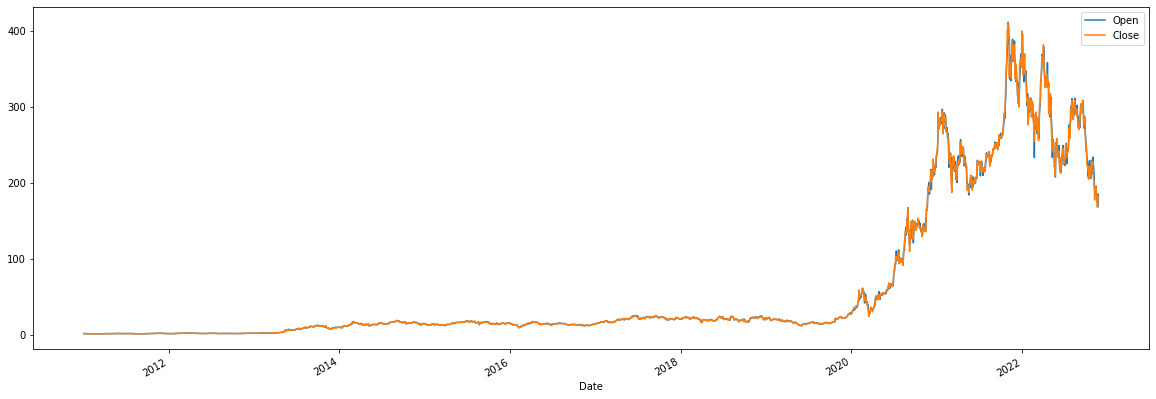

In [ ]:
df[['Open', 'Close']].plot(figsize = (20, 7), alpha = 1)

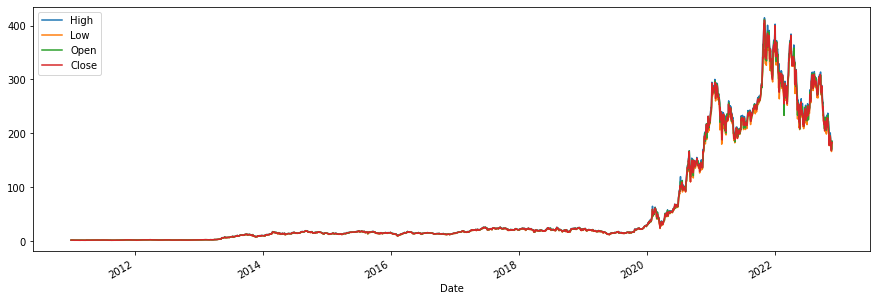

In [ ]:
df[['High','Low','Open','Close']].plot(figsize = (15, 5), alpha = 1)

-->Featire Selection ⬇

**The four attributes had almost same behaviour troughout time and based on this assumption in this project we will only focus on one of them 'Close' in order to build a model which could predict future values.**

Text(0, 0.5, 'Close')

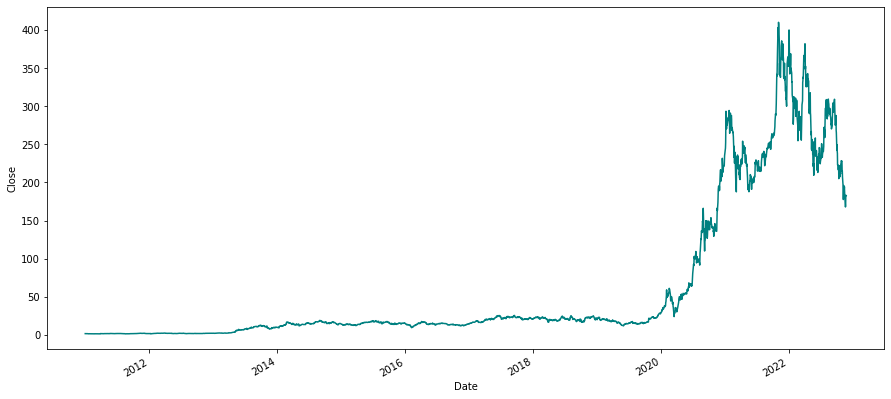

In [ ]:
res=df.Close.plot(figsize=(15, 7), color = 'teal')
res.set_xlabel("Date")
res.set_ylabel("Close")

In [ ]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

**Outlier Removal**

 Z-score is one of the simplest and one of the most popular techniques for outlier detection that works well for several usecases.For specified column, first it computes the Z-score of each value in the column, relative to the column mean and standard deviation. Then is takes the absolute of Z-score because the direction does not matter, only if it is below the threshold. .all(axis=1) ensures that for each row, all column satisfy the constraint. Finally, result of this condition is used to index the dataframe.

 Reference : https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe

In [ ]:

from scipy import stats
df=df[(np.abs(stats.zscore(df['Close'])) < 3)]
df
""""""

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,1.789333,1.800000,1.726667,1.774667,1.774667,19245000
2011-01-04,1.777333,1.796667,1.734667,1.778000,1.778000,17811000
2011-01-05,1.765333,1.793333,1.746000,1.788667,1.788667,21700500
2011-01-06,1.788667,1.866667,1.787333,1.858667,1.858667,30918000
2011-01-07,1.866667,1.905333,1.860000,1.882667,1.882667,33718500
...,...,...,...,...,...,...
2022-11-18,185.050003,185.190002,176.550003,180.190002,180.190002,75904900
2022-11-21,175.850006,176.770004,167.539993,167.869995,167.869995,92882700
2022-11-22,168.630005,170.919998,166.190002,169.910004,169.910004,78452300


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2996 entries, 2011-01-03 to 2022-11-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2996 non-null   float64
 1   High       2996 non-null   float64
 2   Low        2996 non-null   float64
 3   Close      2996 non-null   float64
 4   Adj Close  2996 non-null   float64
 5   Volume     2996 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 163.8 KB


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2996.000000,2996.000000,2996.000000,2996.000000,2996.000000,2.996000e+03
mean,60.542967,61.896180,59.055839,60.504167,60.504167,9.630120e+07
std,96.900174,99.126457,94.391192,96.778412,96.778412,8.186288e+07
min,1.452000,1.484667,1.407333,1.455333,1.455333,3.594000e+06
25%,11.376667,11.633333,11.069667,11.364500,11.364500,4.665412e+07
50%,16.538000,16.785334,16.335333,16.548667,16.548667,7.762505e+07
75%,25.097832,25.525500,24.654832,25.168500,25.168500,1.190614e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [ ]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

A ***correlation matrix*** depicts the correlation between all the possible pairs of values in a table. It is a powerful tool to summarize a large dataset and to identify and visualize patterns in the given data.The correlation matrix helps to predict the evolution of the relationship between the variables. The correlation matrix allows you to have a global view of the more or less strong relationship between several variables.

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
   
    df = df.dropna('columns') # drops columns with Null values
    df = df[[col for col in df if df[col].nunique() > 1]] # keeps columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  after removing the cwd from sys.path.


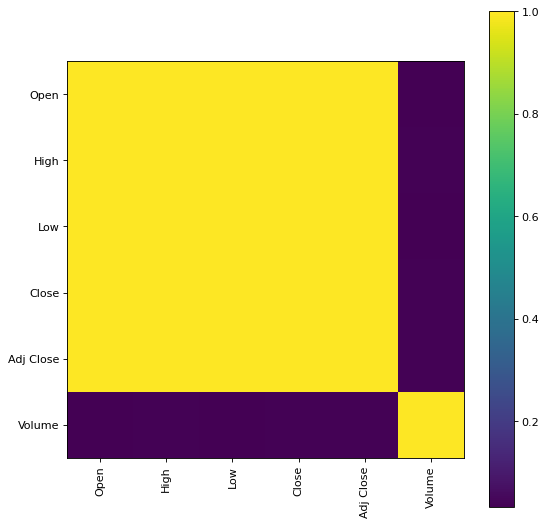

In [ ]:
plotCorrelationMatrix(df, 8)

A ***scatter plot matrix*** is a grid (or matrix) of scatter plots used to visualize bivariate relationships between combinations of variables. Each scatter plot in the matrix visualizes the relationship between a pair of variables, allowing many relationships to be explored in one chart.Scatter plots shows how much one variable is affected by another or the relationship between them with the help of dots in two dimensions.

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keeps only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keeps columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduces the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """


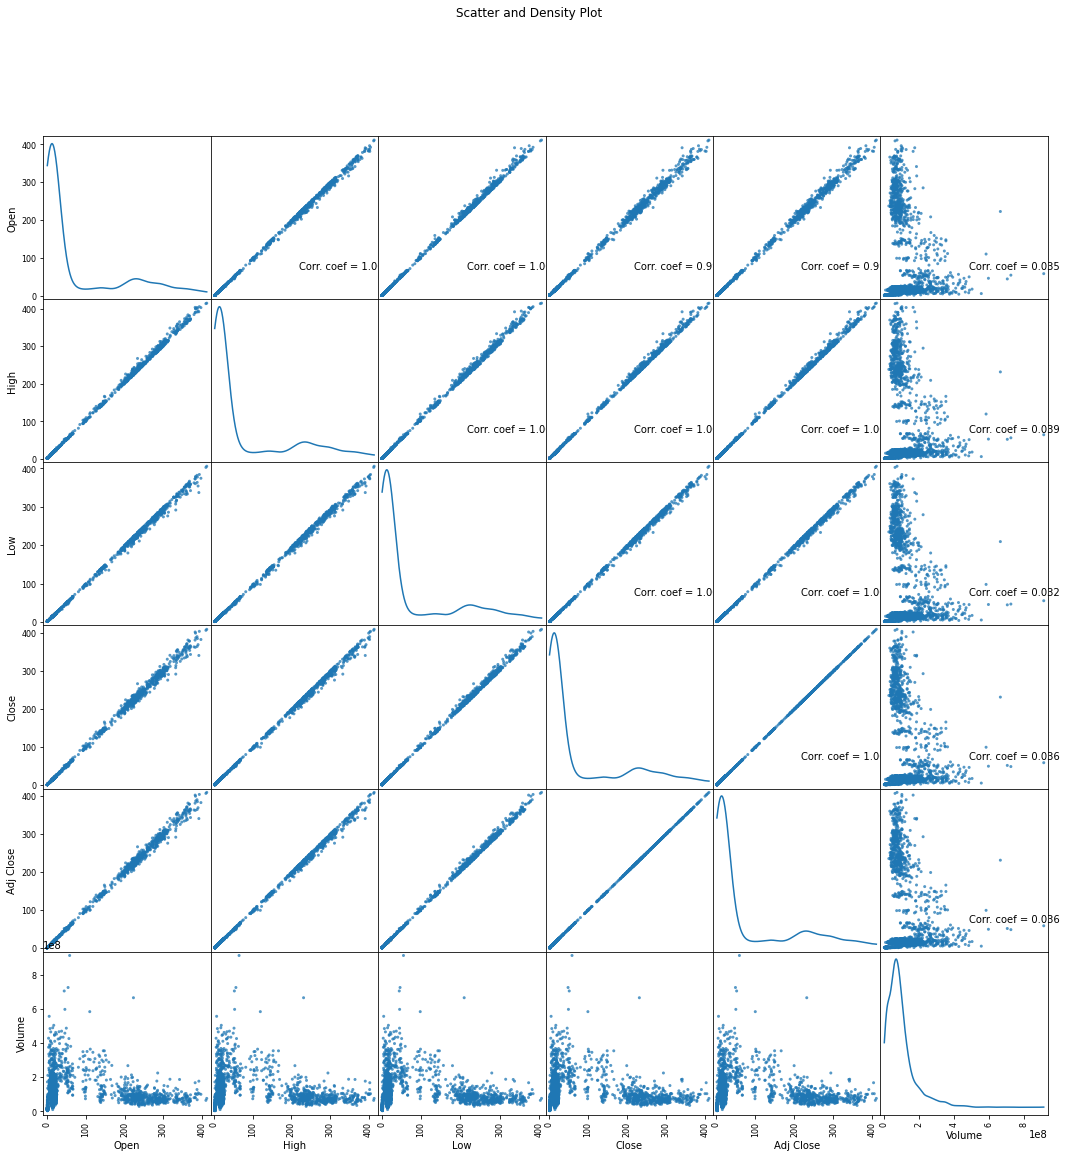

In [ ]:
plotScatterMatrix(df, 18, 10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


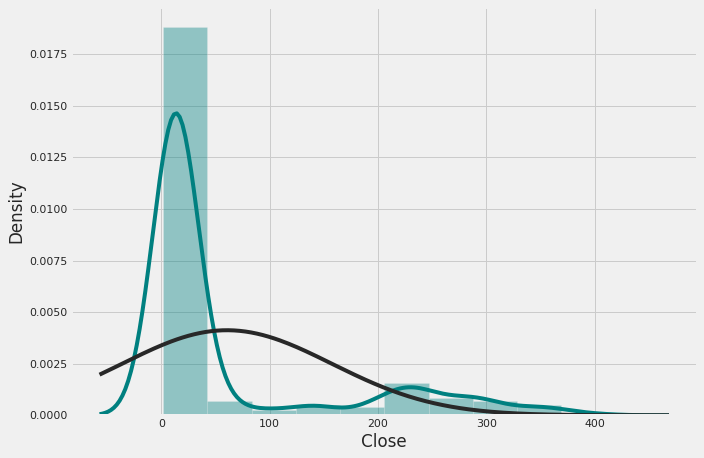

In [ ]:
sns.set()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 7))
sns.distplot(df['Close'],bins=10, fit=norm, kde=True, color='teal')

## Evaluating Stationarity
We will Check if the time-series problem corresponds to a Non-Stationary type, which characterizes for having:



*   Non-constant variance.
*   Non-constant mean.
*   Seasonality.
*   High autocorrelation.


---



Some well known ways to evaluate if the serie meets the criteria above mentioned are:

*   Sequence visualization.
*   Histogram, Autocorrelation and Partial Aurocorrelation plots.
*   Statistical summary of chunks.
*   Adfuller test.


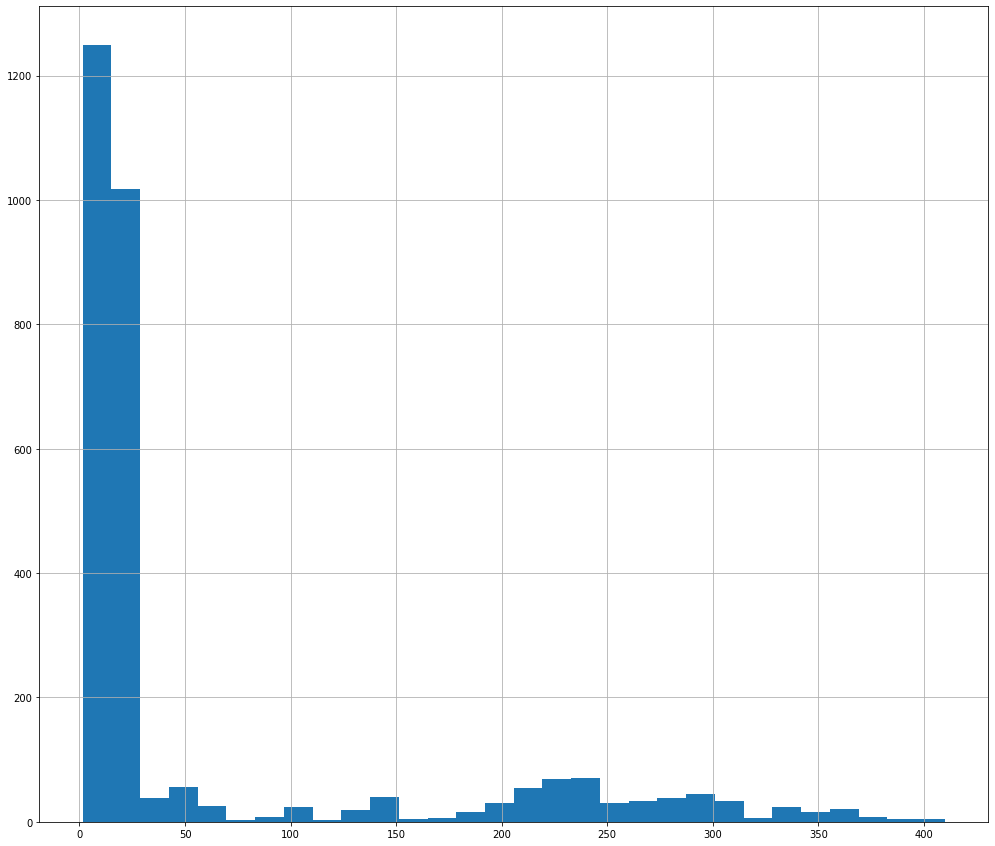

In [ ]:
df.Close.hist(bins=30)

Visually it looks non-stationary.Below we can see the ACF and PACF plots:



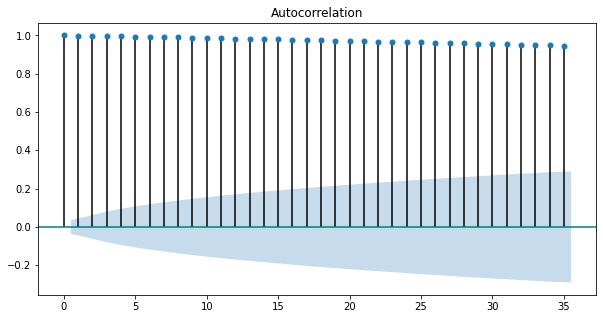

In [ ]:
plt.rc("figure", figsize=(10,5))
plot_acf(df['Close'])
print()

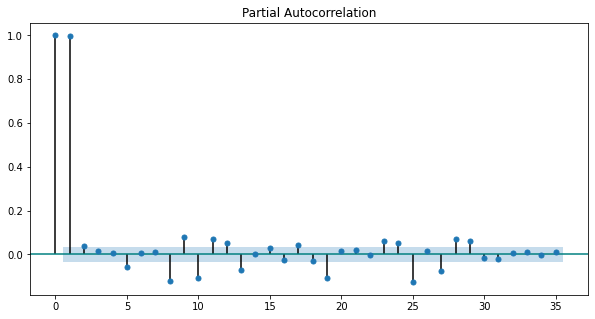

In [ ]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['Close'])
print()

We see if statistical summary can helps us more, for this we will split the data into 10 chunks and compute mean and variance of each one.

In [ ]:
rows=np.round(df.shape[0]/10,0)
rows

300.0

In [ ]:
from statistics import stdev
mean=[]
std=[]
    
for i in range(0,10):
    mean.append(df['Close'].iloc[(i*int(rows)):(i*int(rows))+int(rows)].mean())
    std.append((df['Close'].iloc[(i*int(rows)):(i*int(rows))+int(rows)]).var())

In [ ]:
pd.concat([pd.DataFrame(mean,columns=['mean']),pd.DataFrame(std,columns=['var'])], axis=1)

,mean,var
0,1.867662,0.046183
1,2.434742,0.592639
2,11.868500,8.135494
3,15.999822,2.730678
4,14.398029,1.857385
5,21.204613,8.590678
6,20.831833,4.424494
7,33.867909,454.733005
8,204.797855,2687.881415
9,294.796171,2914.792638


Above we see how both measures are clearly different in each chunk.Thus it is non-stationary data.Now just to be sure we will do the ***Augmented Dickey-Fuller test***.



*   **Null Hypothesis (H0):** the distribution is non-stationary, time-dependent (it has a unit root).
*   **Alternate Hypothesis (H1):** the distribution is stationary, not time-dependent (can’t be represented by a unit root)

The p-value determines the result of the test.We take 0.05 as the threshold or significance level.


*   p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
*   p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Reference:


1.   https://towardsdatascience.com/how-to-remove-non-stationarity-in-time-series-forecasting-563c05c4bfc7
2.   https://machinelearningmastery.com/time-series-data-stationary-python/


In [ ]:
result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.026863
p-value: 0.743341
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


As p-value is greater than 0.05 we fail to reject the null hypothesis, therefore there is not enough evidence to reject that we are working with a non-stationary series. Let's apply the log transformation to the series and test again.

In [ ]:
result = adfuller(log(df['Close']))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.738768
p-value: 0.836451
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Based on every method applied we can endorse the series clearly corresponds to a non-stationary type

#Decomposing Time Series Data
Decomposition is a statistical job that involves breaking down Time Series data into many components or identifying seasonality and trend from a series of data. The following are the components’ definitions:

*   The average value in the series is called the ***level***.
*   The growing or falling value in the series is referred to as the ***trend***.
*   ***Seasonality*** is the series’ recurring/repeating short-term cycle.
*   The random variance in the series is referred to as ***noise***.

In [ ]:
def decompose_add(df, column_name):    
    print("Additive")
    result_add = seasonal_decompose(df[column_name], model = 'additive', extrapolate_trend='freq', period=30)
    plt.style.use('bmh')
    result_add.plot()

    plt.show()
    return result_add

In [ ]:
def decompose_mul(df, column_name):    
    print("Multiplicative")
    result_mul = seasonal_decompose(df[column_name], model='multiplicative', extrapolate_trend = 'freq', period=30)
    plt.style.use('bmh')
    result_mul.plot()

    plt.show()

    return result_mul

Multiplicative


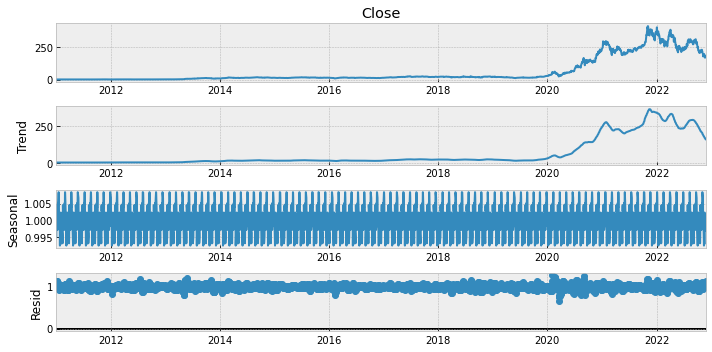

In [ ]:
result_mul=decompose_mul(df, 'Close')

Additive


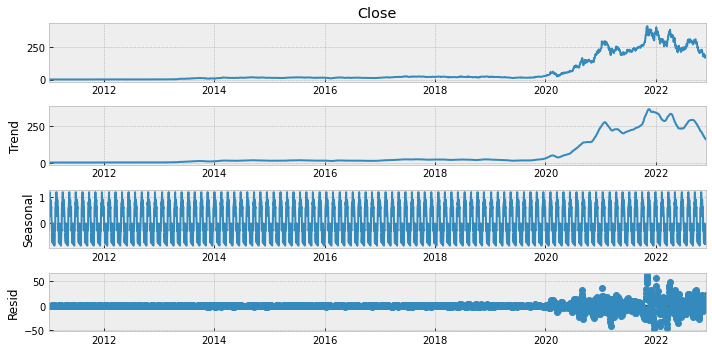

In [ ]:
result_add = decompose_add(df, 'Close')

In [ ]:
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis = 1)
df_reconstructed.columns = ['seasonality', 'trend', 'resid', 'actual_values']
df_reconstructed

,seasonality,trend,resid,actual_values
Date,,,,
2011-01-03,-0.305426,1.668967,0.411125,1.774667
2011-01-04,0.564229,1.666207,-0.452437,1.778000
2011-01-05,0.616109,1.663447,-0.490890,1.788667
2011-01-06,0.795399,1.660687,-0.597419,1.858667
2011-01-07,0.686464,1.657927,-0.461725,1.882667
...,...,...,...,...
2022-11-18,-0.029266,171.425002,8.794266,180.190002
2022-11-21,-0.484478,168.952393,-0.597919,167.869995
2022-11-22,-0.837314,166.479783,4.267535,169.910004


We can use trend or seasonality as features or use

it to study the time-series dataset.

#Modeling


In [ ]:
target_df=df['Close'].iloc[:]
target_df

Date
2011-01-03      1.774667
2011-01-04      1.778000
2011-01-05      1.788667
2011-01-06      1.858667
2011-01-07      1.882667
                 ...    
2022-11-18    180.190002
2022-11-21    167.869995
2022-11-22    169.910004
2022-11-23    183.199997
2022-11-25    182.860001
Name: Close, Length: 2996, dtype: float64

In [ ]:
TRAIN_SIZE = math.ceil(len(target_df)*TRAIN_SPLIT)

In [ ]:
TRAIN_SIZE

2397

#Finding the best Window size.

We will compute the RMSE for the following number of windows: 5,8,10,15,20,30,40. Then compare results and find the lowest.

In [ ]:
train_error=[]
val_error=[]

window_number=[5,8,10,15,20,30,40]
for i in window_number:

    train_data = target_df[0:TRAIN_SIZE]

    X_train=[]
    Y_train=[]

    for i in range(window, len(train_data)):
        X_train.append(train_data[i-window:i])
        Y_train.append(train_data[i])

    X_train, Y_train= np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    test_data = target_df[TRAIN_SIZE-window:]

    X_val=[]
    Y_val=[] 

    for i in range(window, len(test_data)):
        X_val.append(test_data[i-window:i])
        Y_val.append(test_data[i])

    X_val, Y_val = np.array(X_val), np.array(Y_val)
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

    model=Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    train_error.append(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
    val_error.append(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

19/19 [==============================] - 0s 4ms/step


In [ ]:
train_error

[1.0084490968384534,
 1.5537528229113282,
 0.928652901685027,
 0.9307022344795775,
 0.8406597986817761,
 0.8936447070350572,
 1.6139009372347177]

In [ ]:
val_error

[31.303031440395106,
 41.73244763598399,
 12.435938130904061,
 30.536342823880364,
 24.929325633957177,
 17.085793697404412,
 80.85146303561783]

The following table shows the RMSE of train and validation sets for each of the 7 windows:

In [ ]:
pd.concat([pd.DataFrame(train_error,columns=['train_error']),
           pd.DataFrame(val_error,columns=['val_error']),
           pd.DataFrame([5,8,10,15,20,30,40],columns=['window'])], axis=1).set_index('window')

,train_error,val_error
window,,
5,1.008449,31.303031
8,1.553753,41.732448
10,0.928653,12.435938
15,0.930702,30.536343
20,0.840660,24.929326
30,0.893645,17.085794
40,1.613901,80.851463


We checked the results for different Window sizes multiple time and each time the results were different . However , the results were usually best at 10 or 15 so we have used either of these 2 as window size's interchaneably.  


#Simple LSTM

Let's use 10 as a random window to be used in the model to build.
The following is the first model to be used, this is relatively simple with one LSTM layer with relu activation function and one hidden fully connected layer, the optimizer used is Adam, number of epochs=10, batch_size=10 and loss function=Mean squared error

Reference:https://www.kaggle.com/code/rafetcan/long-short-term-memory-n-lstm-for-beginners

In [ ]:
window=10

***Window size*** means that for  that much elements the future value is predicted.

In [ ]:
train_data =target_df[0:TRAIN_SIZE]

X_train=[]
Y_train=[]

for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

In [ ]:
X_train, Y_train= np.array(X_train), np.array(Y_train)

Reshaping the training set to (number of records-window, number of time steps, 1)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2387, 10, 1)

In [ ]:
X_train

array([[[  1.774667],
        [  1.778   ],
        [  1.788667],
        ...,
        [  1.797333],
        [  1.748   ],
        [  1.716667]],

       [[  1.778   ],
        [  1.788667],
        [  1.858667],
        ...,
        [  1.748   ],
        [  1.716667],
        [  1.709333]],

       [[  1.788667],
        [  1.858667],
        [  1.882667],
        ...,
        [  1.716667],
        [  1.709333],
        [  1.602   ]],

       ...,

       [[ 64.056664],
        [ 65.732002],
        [ 63.982666],
        ...,
        [ 91.438667],
        [ 92.657333],
        [ 91.05867 ]],

       [[ 65.732002],
        [ 63.982666],
        [ 67.290001],
        ...,
        [ 92.657333],
        [ 91.05867 ],
        [ 92.952003]],

       [[ 63.982666],
        [ 67.290001],
        [ 71.987335],
        ...,
        [ 91.05867 ],
        [ 92.952003],
        [102.976669]]])

In [ ]:
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_data = target_df[TRAIN_SIZE-window:]

X_val=[]
Y_val=[] 

for i in range(window, len(test_data)):
    X_val.append(test_data[i-window:i])
    Y_val.append(test_data[i])

In [ ]:
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

In [ ]:
X_val.shape, Y_val.shape

((599, 10, 1), (599,))

In [ ]:
prediction = model.predict(X_val)

19/19 [==============================] - 0s 3ms/step


In [ ]:
len(prediction), len(Y_val)

(599, 599)

As our prediction and actual values have the same shape we can use these sets to compute the error metrics, in this case we will use RMSE.

In [ ]:
lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

19/19 [==============================] - 0s 3ms/step
Train rmse: 1.067401785633926
Validation rmse: 18.169694955253366


In [ ]:
valid = pd.DataFrame(target_df[TRAIN_SIZE:])
valid['Predictions']=lstm_valid_pred
valid

,Close,Predictions
Date,,
2020-07-14,101.120003,97.811073
2020-07-15,103.067329,99.515106
2020-07-16,100.042664,101.684822
2020-07-17,100.056000,100.568817
2020-07-20,109.533333,100.843994
...,...,...
2022-11-18,180.190002,196.211884
2022-11-21,167.869995,194.336761
2022-11-22,169.910004,184.615448


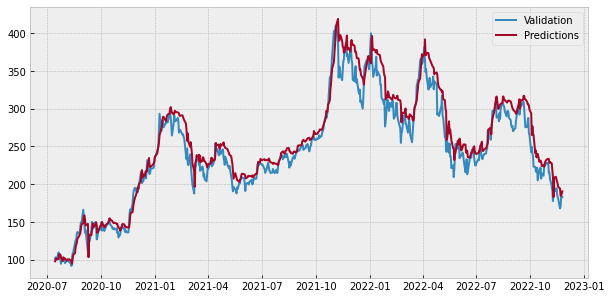

In [ ]:
plt.plot(valid[['Close','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

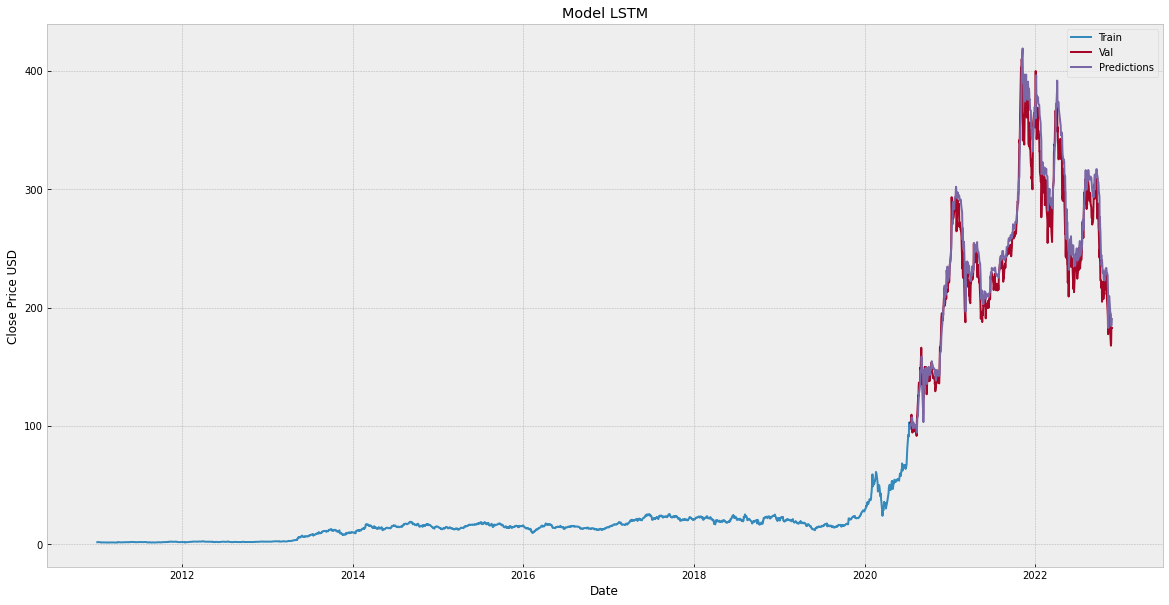

In [ ]:
train = target_df[:TRAIN_SIZE]
valid = pd.DataFrame(target_df[TRAIN_SIZE:])
valid['Predictions']=lstm_valid_pred

plt.figure(figsize=(20,10))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train)
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'])
plt.show()

#LSTM with more Layers

We increase the complexity of the model which can be achieved adding more layers and more LSTM cells. Therefore in this step we get build a multilayered model and compare its performance with the prior.

In [ ]:
window=15

train_data = target_df[0:TRAIN_SIZE]
X_train=[]
Y_train=[]
for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

X_train, Y_train= np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


test_data =target_df[TRAIN_SIZE-window:]
X_val=[]
Y_val=[] 
for i in range(window, len(test_data)):
    X_val.append(test_data[i-window:i])
    Y_val.append(test_data[i])
    
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))


The following is the architecture of the model to be used (2 LSTM layers and 2 hidden fully-connected layers), the optimizer is more specific and the number of epochs was increased to 100:

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dense(25))
model.add(Dense(1))
opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=opt1)
model.summary()
model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=0)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 15, 50)            10400     
                                                                 
 lstm_45 (LSTM)              (None, 50)                20200     
                                                                 
 dense_84 (Dense)            (None, 100)               5100      
                                                                 
 dense_85 (Dense)            (None, 25)                2525      
                                                                 
 dense_86 (Dense)            (None, 1)                 26        
                                                                 
Total params: 38,251
Trainable params: 38,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

19/19 [==============================] - 0s 7ms/step
Train rmse: 0.8906835053355855
Validation rmse: 17.26331888695386


In [ ]:
valid = pd.DataFrame(target_df[TRAIN_SIZE:])
valid['Predictions']=lstm_valid_pred

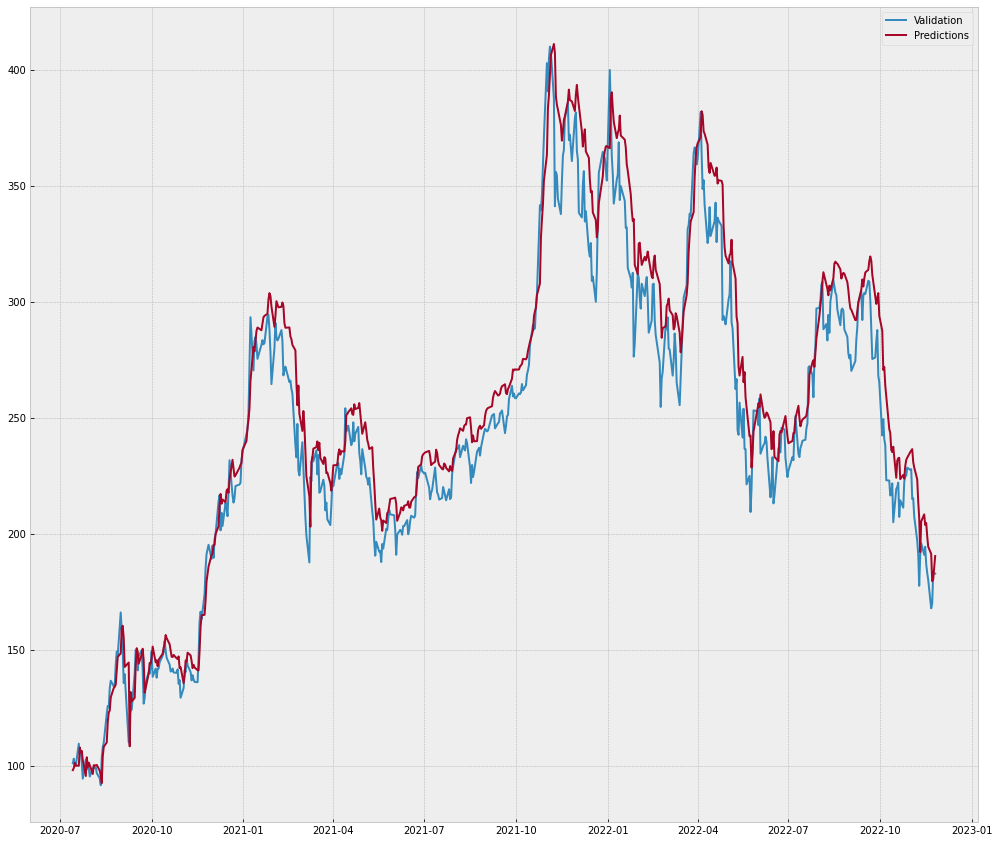

In [ ]:
plt.plot(valid[['Close','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

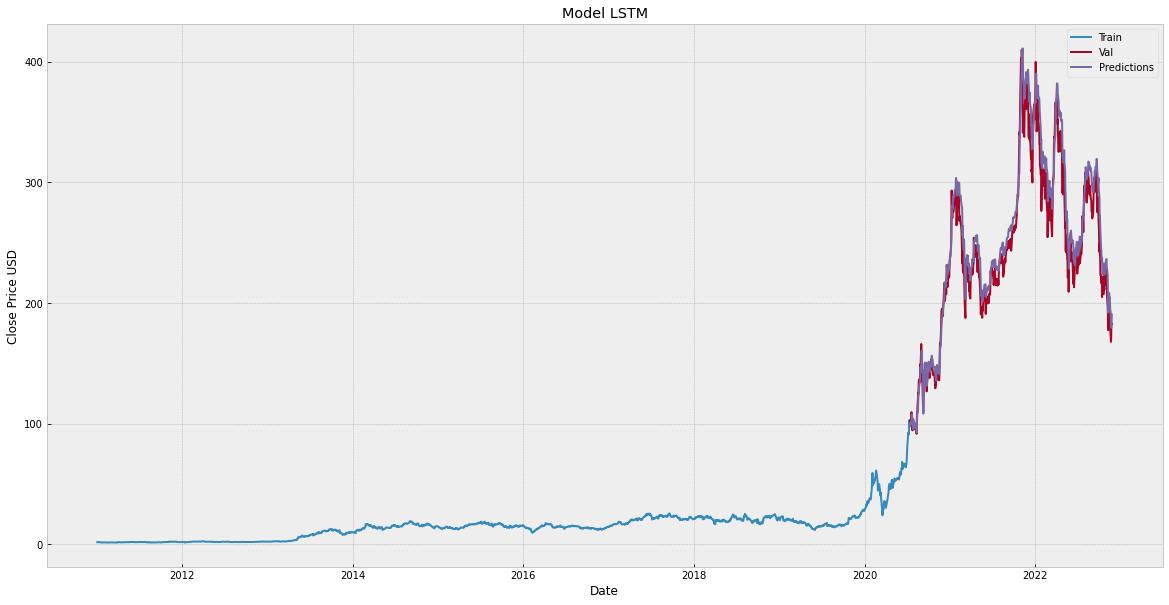

In [ ]:
train = target_df[:TRAIN_SIZE]
valid = pd.DataFrame(target_df[TRAIN_SIZE:])
valid['Predictions']=lstm_valid_pred

plt.figure(figsize=(20,10))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train)
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'])
plt.show()

 We've found that each time I ran this model the results were different.In order to better vizualize this we ran 10 times the same model and compute the errors in each one

In [ ]:
train_error=[]
test_error=[]

for i in range(0,10):
    model=Sequential()
    model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(LSTM(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dense(25))
    model.add(Dense(1))
    opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    train_error.append(np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2))
    test_error.append(np.round(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)),2))

19/19 [==============================] - 0s 6ms/step


In [ ]:
train_error, statistics.mean(train_error), statistics.stdev(train_error)

([0.89, 0.9, 0.82, 1.14, 0.85, 0.78, 0.86, 0.87, 0.87, 0.88],
 0.886,
 0.09593979593705858)

In [ ]:
test_error, statistics.mean(test_error), statistics.stdev(test_error)

([67.65, 23.17, 15.0, 34.98, 70.81, 84.22, 41.23, 27.2, 144.41, 34.73],
 54.339999999999996,
 38.931355828774656)

The results from just the LSTM are not that well and deviate with each iteration greatly.

#LSTM with Drop-out

As the testing errors were still considerably higher than training we think one reason could be due to overfitting and for this problem we have to add regularization to the model chosen by using Dropout after Fully Connected layers and LSTM cells. In this step we will run a regularized model again 10 times in order to see the variation in the results

In [ ]:
train_error=[]
test_error=[]

for i in range(0,10):
    model=Sequential()
    model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1),recurrent_dropout=0.2))
    model.add(LSTM(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    train_error.append(np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2))
    test_error.append(np.round(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)),2))
    print(f"{i} iteration done")

19/19 [==============================] - 0s 7ms/step
0 iteration done
19/19 [==============================] - 0s 7ms/step
1 iteration done
19/19 [==============================] - 0s 6ms/step
2 iteration done
19/19 [==============================] - 0s 7ms/step
3 iteration done
19/19 [==============================] - 0s 7ms/step
4 iteration done
19/19 [==============================] - 0s 8ms/step
5 iteration done
19/19 [==============================] - 0s 7ms/step
6 iteration done
19/19 [==============================] - 0s 7ms/step
7 iteration done
19/19 [==============================] - 0s 6ms/step
8 iteration done
19/19 [==============================] - 0s 7ms/step
9 iteration done


In [ ]:
train_error, statistics.mean(train_error), statistics.stdev(train_error)

([0.84, 0.87, 1.78, 0.87, 1.68, 1.01, 0.84, 0.84, 1.07, 1.02],
 1.082,
 0.35269754118161295)

In [ ]:
test_error, statistics.mean(test_error), statistics.stdev(test_error)

([12.19, 40.58, 12.58, 12.79, 17.53, 10.96, 18.14, 28.44, 10.98, 38.67],
 20.286,
 11.465891640474853)

The results from using the reqularization technique (Drop-out) for the Test Dataset are better than just simply using the model.

#CNN LSTM

Input shape [samples, subsequences, timesteps, features]

"The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."

"When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."

"The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

Reference : https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/

In [ ]:
window=30 # has to be even for CNN-LSTM
train_data =target_df[0:TRAIN_SIZE]

X_train=[]
Y_train=[]

for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

In [ ]:
X_train, Y_train= np.array(X_train), np.array(Y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2367, 30, 1)

In [ ]:
X_train.shape,Y_train.shape

((2367, 30, 1), (2367,))

In [ ]:
test_data = target_df[TRAIN_SIZE-window:]

X_val=[]
Y_val=[] 

for i in range(window, len(test_data)):
    X_val.append(test_data[i-window:i])
    Y_val.append(test_data[i])

In [ ]:
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [ ]:

X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

In [ ]:
X_val.shape, Y_val.shape


((599, 30, 1), (599,))

In [ ]:
X_train_series=X_train
X_valid_series=X_val

subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (2367, 2, 15, 1)
Validation set shape (599, 2, 15, 1)


In [ ]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import  Flatten
from keras import optimizers
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_val), epochs=epochs, verbose=2)

Epoch 1/40
74/74 - 2s - loss: 67.1505 - val_loss: 1498.0858 - 2s/epoch - 28ms/step
Epoch 2/40
74/74 - 0s - loss: 7.7367 - val_loss: 922.9741 - 470ms/epoch - 6ms/step
Epoch 3/40
74/74 - 0s - loss: 6.0137 - val_loss: 516.8996 - 492ms/epoch - 7ms/step
Epoch 4/40
74/74 - 0s - loss: 4.5337 - val_loss: 961.9932 - 454ms/epoch - 6ms/step
Epoch 5/40
74/74 - 0s - loss: 3.8395 - val_loss: 517.3762 - 495ms/epoch - 7ms/step
Epoch 6/40
74/74 - 0s - loss: 2.8929 - val_loss: 827.9598 - 478ms/epoch - 6ms/step
Epoch 7/40
74/74 - 0s - loss: 3.1468 - val_loss: 617.6208 - 487ms/epoch - 7ms/step
Epoch 8/40
74/74 - 0s - loss: 2.7069 - val_loss: 1239.5632 - 486ms/epoch - 7ms/step
Epoch 9/40
74/74 - 0s - loss: 2.9109 - val_loss: 2229.4563 - 474ms/epoch - 6ms/step
Epoch 10/40
74/74 - 0s - loss: 3.0665 - val_loss: 3611.9407 - 485ms/epoch - 7ms/step
Epoch 11/40
74/74 - 0s - loss: 2.5626 - val_loss: 851.9471 - 443ms/epoch - 6ms/step
Epoch 12/40
74/74 - 0s - loss: 2.0895 - val_loss: 693.2849 - 465ms/epoch - 6ms/ste

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, cnn_lstm_valid_pred)))

19/19 [==============================] - 0s 3ms/step
Train rmse: 1.2381534071935014
Validation rmse: 26.591030386323716


In [ ]:
cnn_lstm_valid_pred.shape

(599, 1)

In [ ]:
valid = pd.DataFrame(target_df[TRAIN_SIZE:])
valid['Predictions']=cnn_lstm_valid_pred
valid

,Close,Predictions
Date,,
2020-07-14,101.120003,101.433380
2020-07-15,103.067329,101.785889
2020-07-16,100.042664,103.026619
2020-07-17,100.056000,105.600357
2020-07-20,109.533333,104.855316
...,...,...
2022-11-18,180.190002,160.651962
2022-11-21,167.869995,157.507339
2022-11-22,169.910004,156.517227


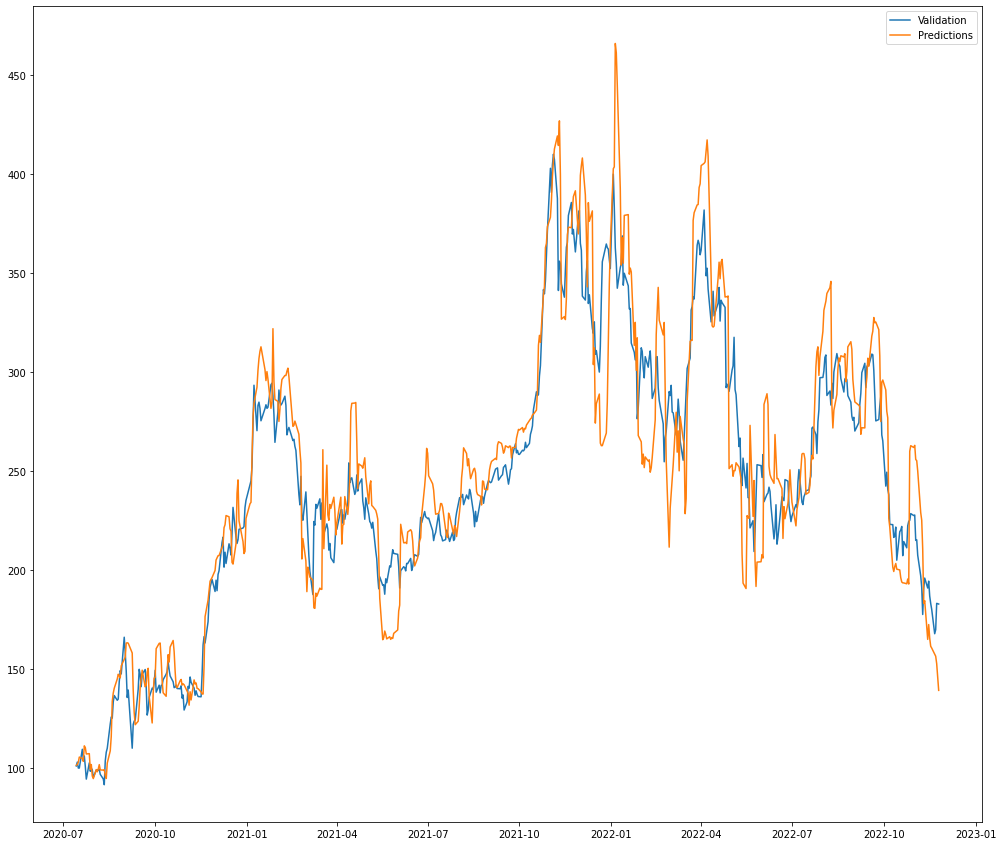

In [ ]:
plt.plot(valid[['Close','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

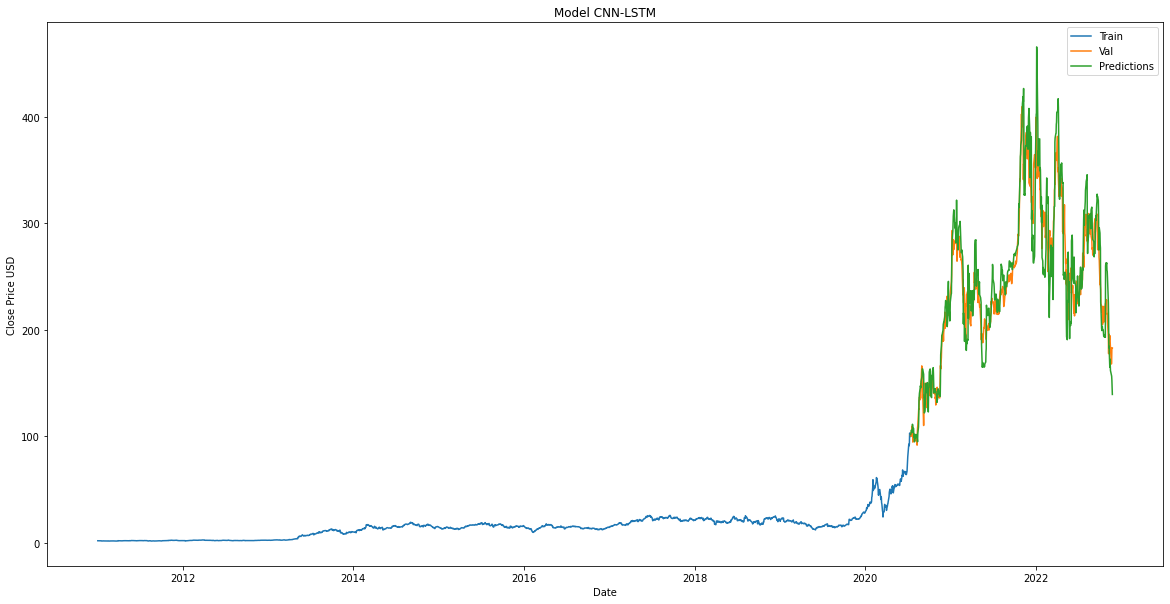

In [ ]:
train = target_df[:TRAIN_SIZE]
valid = pd.DataFrame(target_df[TRAIN_SIZE:])
valid['Predictions']=cnn_lstm_valid_pred

plt.figure(figsize=(20,10))
plt.title('Model CNN-LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train)
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'])
plt.show()

We don't see any benefit of using CNN with LSTM rather than just the simple LSTM

#SimpleRNN

Reference : https://www.kaggle.com/code/rafetcan/recurrent-neural-n-rnn-tutorial-for-beginners

In [ ]:
train_error=[]
test_error=[]

for i in range(0,10):
    model=Sequential()
    model.add(SimpleRNN(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(SimpleRNN(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dense(25))
    model.add(Dense(1))
    opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    train_error.append(np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2))
    test_error.append(np.round(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)),2))

19/19 [==============================] - 0s 4ms/step


In [ ]:
#print(f"Training error for different iterations are {train_error} \n The mean of training errors is {statistics.mean(train_error)} and the standard deviation of training errors is {statistics.stdev(train_error)}")
train_error, statistics.mean(train_error), statistics.stdev(train_error)

([0.81, 0.96, 0.96, 0.83, 0.91, 0.81, 1.15, 1.18, 0.83, 0.84],
 0.9279999999999999,
 0.13742068419435421)

In [ ]:
test_error, statistics.mean(test_error), statistics.stdev(test_error)

([10.47, 10.97, 10.85, 11.01, 12.06, 10.2, 13.2, 13.25, 11.07, 10.23],
 11.331,
 1.1290453194328973)

We get the most consistent results with a Simple-RNN doe the test dataset.The standard deviation between all the results is the least with the RNN.

#ARIMA

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime

<ipython-input-3-75537721b9e7>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [4]:
arima_data = pd.read_csv(DATASET_PATH)

We do not need to covnert this data into non-stationary, it does that automatically. 

https://stats.stackexchange.com/questions/394796/should-my-time-series-be-stationary-to-use-arima-model#:~:text=ARIMA%20models%20cannot%20handle%20any%20type%20of%20non%2Dstationarity

In [5]:
arima_data = arima_data[["Date", "Close"]]
arima_data.set_index("Date", drop=True, append=False, inplace=False, verify_integrity=False)

,Close
Date,
2011-01-03,1.774667
2011-01-04,1.778000
2011-01-05,1.788667
2011-01-06,1.858667
2011-01-07,1.882667
...,...
2022-11-18,180.190002
2022-11-21,167.869995
2022-11-22,169.910004


In [6]:
model = ARIMA(np.asarray(arima_data[["Close"]]), order=(5,1,0))
model_fit = model.fit()

In [7]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2996
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8732.682
Date:                Thu, 08 Dec 2022   AIC                          17477.364
Time:                        12:40:31   BIC                          17513.393
Sample:                             0   HQIC                         17490.325
                               - 2996                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0391      0.008     -4.891      0.000      -0.055      -0.023
ar.L2          0.0119      0.007      1.739      0.082      -0.002       0.025
ar.L3          0.0011      0.009      0.127      0.899      -0.016       0.018
ar.L4          0.0315      0.007      4.261      0.000       0.017       0.046
ar.L5         -0.0163      0.007     -2.295      0.022      -0.030      -0.002
sigma2        19.9579      0.144    138.397      0.000      19.675      20.241
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             76500.09
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             792.61   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

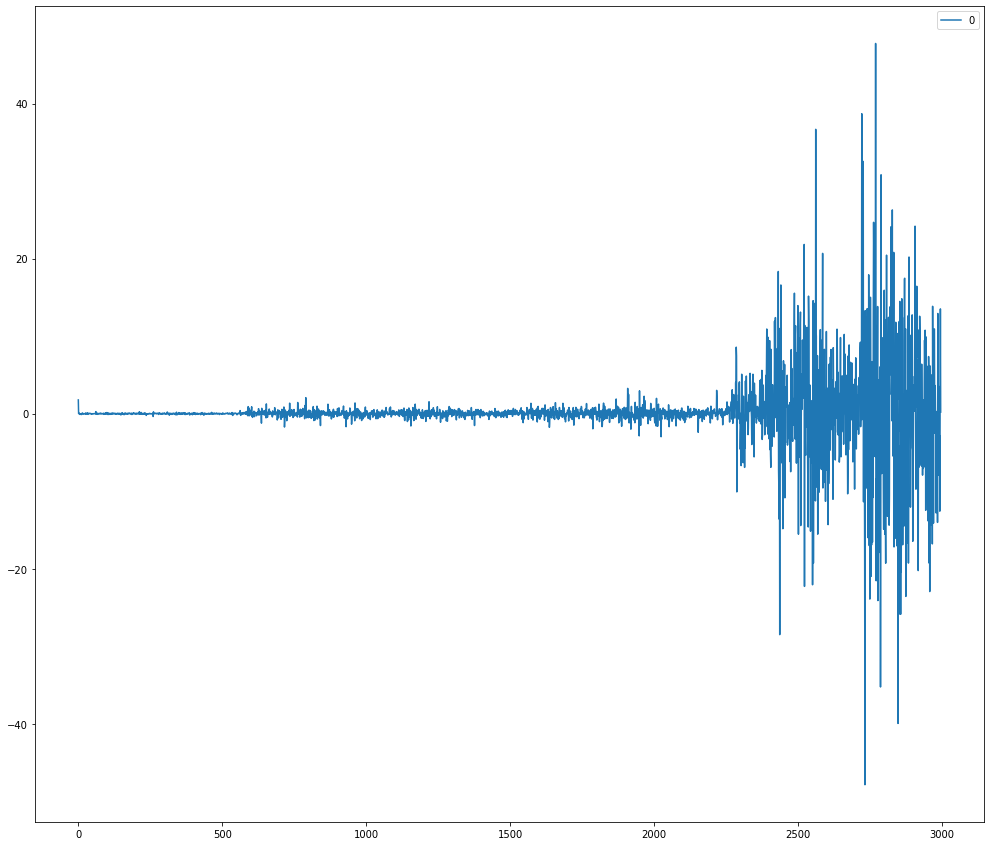

In [8]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

In [ ]:
X = arima_data[["Close"]].values
size = int(len(X) * TEST_SPLIT)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()